In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import numpy as np

In [2]:
class Inner(nn.Module):
    """
    Learner for the inner loop
    """
    def __init__(self, config):
        """

        :param config: network config file, type:list of (string, list)
        """
        super(Inner, self).__init__()
        self.config = config
        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        for i, (name, param) in enumerate(self.config):
            if name is 'conv2d':
                # [ch_out, ch_in, kernelsz, kernelsz]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))
            elif name is 'convt2d':
                # [ch_in, ch_out, kernelsz, kernelsz, stride, padding]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_in, ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[1])))
            elif name is 'linear':
                # [ch_out, ch_in]
                w = nn.Parameter(torch.ones(*param))
                # gain=1 according to cbfinn's implementation
                nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))
            elif name is 'bn':
                # [ch_out]
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))
                # must set requires_grad=False
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])
            elif name in ['tanh', 'relu', 'upsample', 'avg_pool2d', 'max_pool2d',
                          'flatten', 'reshape', 'leakyrelu', 'sigmoid']:
                continue
            else:
                raise NotImplementedError

    def extra_repr(self):
        info = ''
        for name, param in self.config:
            if name is 'conv2d':
                tmp = 'conv2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[1], param[0], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'
            elif name is 'convt2d':
                tmp = 'convTranspose2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[0], param[1], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'
            elif name is 'linear':
                tmp = 'linear:(in:%d, out:%d)'%(param[1], param[0])
                info += tmp + '\n'
            elif name is 'leakyrelu':
                tmp = 'leakyrelu:(slope:%f)'%(param[0])
                info += tmp + '\n'
            elif name is 'avg_pool2d':
                tmp = 'avg_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name is 'max_pool2d':
                tmp = 'max_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name in ['flatten', 'tanh', 'relu', 'upsample', 'reshape', 'sigmoid', 'use_logits', 'bn']:
                tmp = name + ':' + str(tuple(param))
                info += tmp + '\n'
            else:
                raise NotImplementedError

        return info

    def forward(self, x, vars=None, bn_training=True):
        """
        This function can be called by finetunning, however, in finetunning, we dont wish to update
        running_mean/running_var. Thought weights/bias of bn is updated, it has been separated by fast_weights.
        Indeed, to not update running_mean/running_var, we need set update_bn_statistics=False
        but weight/bias will be updated and not dirty initial theta parameters via fast_weiths.
        :param x: [b, 1, 28, 28]
        :param vars:
        :param bn_training: set False to not update
        :return: x, loss, likelihood, kld
        """
        if vars is None:
            vars = self.vars

        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'convt2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv_transpose2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
                # print('forward:', idx, x.norm().item())
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2
            elif name is 'flatten':
                # print(x.shape)
                x = x.view(x.size(0), -1)
            elif name is 'reshape':
                # [b, 8] => [b, 2, 2, 2]
                x = x.view(x.size(0), *param)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'leakyrelu':
                x = F.leaky_relu(x, negative_slope=param[0], inplace=param[1])
            elif name is 'tanh':
                x = F.tanh(x)
            elif name is 'sigmoid':
                x = torch.sigmoid(x)
            elif name is 'upsample':
                x = F.upsample_nearest(x, scale_factor=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])
            elif name is 'avg_pool2d':
                x = F.avg_pool2d(x, param[0], param[1], param[2])
            else:
                raise NotImplementedError

        # make sure variable is used properly
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)
        return x


    def zero_grad(self, vars=None):
        """

        :param vars:
        :return:
        """
        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """        
        return self.vars

In [3]:
from copy import deepcopy

class Outer(nn.Module):
    """
    Meta learner for the outer loop
    """
    def __init__(self, args, config=None):
        """

        :param args:
        :param config: network config file, type:list of (string, list)
        """
        super(Outer, self).__init__()
        self.task_num = args['task_num']
        self.inner_step = args['inner_step']
        self.inner_lr = args['inner_lr']
        self.class_num = args['class_num'] # default 1 for non-classification problem
        self.train_sample_size_per_class = args['train_sample_size_per_class']
        self.test_sample_size_per_class = args['test_sample_size_per_class'] # the same as train_sample_size_per_class by default
        #self.update_step_test = args.update_step_test
        if args['data_source'] == 'sinusoid':
            self.classification = False
            self.loss_func = F.mse_loss
            if config is None:
                config = [('linear', [40, 1]),
                          ('relu', [True]),
                          ('linear', [40, 40]),
                          ('relu', [True]),
                          ('linear', [1, 40])]
        elif args['data_source'] == 'omniglot' or args.data_source == 'miniimagenet':
            self.classification = True
            self.loss_func = F.cross_entropy
            if config is None:
                config =[('conv2d', [64, 1, 3, 3, 2, 0]),
                         ('relu', [True]),
                         ('bn', [64]),
                         ('conv2d', [64, 64, 3, 3, 2, 0]),
                         ('relu', [True]),
                         ('bn', [64]),
                         ('conv2d', [64, 64, 3, 3, 2, 0]),
                         ('relu', [True]),
                         ('bn', [64]),
                         ('conv2d', [64, 64, 2, 2, 1, 0]),
                         ('relu', [True]),
                         ('bn', [64]),
                         ('flatten', []),
                         ('linear', [self.class_num, 64])]
        else:
            raise NotImplementedError
        self.model = Inner(config)

    def forward(self, x_train, y_train, x_test):
        """

        :param x_train:  [task_num, class_num*train_sample_size_per_class, input_size]
        :param y_train:  [task_num, class_num*train_sample_size_per_class, output_size]
        :param x_test:   [task_num, class_num*test_sample_size_per_class, input_size]
        :return:
        """
        output_size = (self.task_num, self.class_num * self.test_sample_size_per_class)
        if self.classification:
            output_size += (self.class_num,)
            output = y_train.new_empty(output_size, dtype=torch.float)
        else:
            output_size += y_train.shape[2:]
            output = y_train.new_empty(output_size)
              
        for i in range(self.task_num):
            # the first step of the inner loop
            output_inner = self.model(x_train[i], self.model.parameters(), bn_training=True) #logits
            loss_inner = self.loss_func(output_inner, y_train[i]) #loss = F.cross_entropy(logits, y_spt[i])
            grad = torch.autograd.grad(loss_inner, self.model.parameters())
            fast_weights = list(map(lambda p: p[1] - self.inner_lr * p[0], zip(grad, self.model.parameters())))
            # the rest of the inner loop
            for _ in range(1, self.inner_step):
                output_inner = self.model(x_train[i], fast_weights, bn_training=True)
                loss_inner = self.loss_func(output_inner, y_train[i])
                grad = torch.autograd.grad(loss_inner, fast_weights)
                fast_weights = list(map(lambda p: p[1] - self.inner_lr * p[0], zip(grad, fast_weights)))
            # calculate output of the outer loop
            output[i] = self.model(x_test[i], fast_weights, bn_training=True)
            
        return output
    
    def fine_tuning(self, x_train, y_train, x_test, y_test):
        """

        :param x_train:  [task_num, class_num*train_sample_size_per_class, input_size]
        :param y_train:  [task_num, class_num*train_sample_size_per_class, output_size]
        :param x_test:   [task_num, class_num*test_sample_size_per_class, input_size]
        :param y_test:   [task_num, class_num*test_sample_size_per_class, output_size]
        :return:
        """
        # record the first training error and all-step test errors during fine-tuning
        loss_summary = np.zeros(self.inner_step + 2)
        if self.classification: 
            accuracy_summary = np.zeros(self.inner_step + 2)
        
        model = deepcopy(self.model)
              
        for i in range(self.task_num):
            # the first step of the inner loop
            output_inner = model(x_train[i], model.parameters(), bn_training=True) #logits
            loss_inner = self.loss_func(output_inner, y_train[i]) #loss = F.cross_entropy(logits, y_spt[i])
            ## train error before update
            loss_summary[0] += loss_inner.item()                
            grad = torch.autograd.grad(loss_inner, model.parameters())
            fast_weights = list(map(lambda p: p[1] - self.inner_lr * p[0], zip(grad, model.parameters())))
            if self.classification:
                with torch.no_grad():
                    y_pred_inner = F.softmax(output_inner, dim=1).argmax(dim=1)
                    accuracy_summary[0] += torch.eq(y_pred_inner, y_train[i]).to(torch.float).mean().item()
            ## test error before update
            with torch.no_grad():
                output_test = model(x_test[i], model.parameters(), bn_training=True)
                loss_test = self.loss_func(output_test, y_test[i])
                loss_summary[1] += loss_test.item()
                if self.classification:
                    y_pred_test = F.softmax(output_test, dim=1).argmax(dim=1)
                    accuracy_summary[1] += torch.eq(y_pred_test, y_test[i]).to(torch.float).mean().item()
            ## test error after the first update
            with torch.no_grad():
                output_test = model(x_test[i], fast_weights, bn_training=True)
                loss_test = self.loss_func(output_test, y_test[i])
                loss_summary[2] += loss_test.item()
                if self.classification:
                    y_pred_test = F.softmax(output_test, dim=1).argmax(dim=1)
                    accuracy_summary[2] += torch.eq(y_pred_test, y_test[i]).to(torch.float).mean().item()
            # the rest of the inner loop
            for j in range(1, self.inner_step):
                output_inner = model(x_train[i], fast_weights, bn_training=True)
                loss_inner = self.loss_func(output_inner, y_train[i])
                grad = torch.autograd.grad(loss_inner, fast_weights)
                fast_weights = list(map(lambda p: p[1] - self.inner_lr * p[0], zip(grad, fast_weights)))
                with torch.no_grad():
                    output_test = model(x_test[i], fast_weights, bn_training=True)
                    loss_test = self.loss_func(output_test, y_test[i])
                    loss_summary[j + 2] += loss_test.item()
                    if self.classification:
                        y_pred_test = F.softmax(output_test, dim=1).argmax(dim=1)
                        accuracy_summary[j + 2] += torch.eq(y_pred_test, y_test[i]).to(torch.float).mean().item()
            
        del model 
        if self.classification:
            return loss_summary/self.task_num, accuracy_summary/self.task_num
        else:
            return loss_summary/self.task_num

In [4]:
import os
import random
from omniglot import Omniglot
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict

class DataGenerator(object):
    """
    Data Generator capable of generating batches of sinusoid data.
    A "class" is considered a particular sinusoid function.
    """
    def __init__(self, args):
        """
        Args:
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.task_num = args['task_num']
        self.class_num = args['class_num']
        self.train_sample_size_per_class = args['train_sample_size_per_class']
        self.test_sample_size_per_class = args['test_sample_size_per_class']
        self.sample_size_per_class = self.train_sample_size_per_class + self.test_sample_size_per_class
        if args['data_source'] == 'sinusoid':
            self.generate = self.generate_sinusoid_batch
            self.amp_range = args['data_config'].get('amp_range', [0.1, 5.0])
            self.phase_range = args['data_config'].get('phase_range', [0, np.pi])
            self.input_range = args['data_config'].get('input_range', [-5.0, 5.0])
            self.dim_input = 1
            self.dim_output = 1
        elif args['data_source'] == 'omniglot':
            assert self.sample_size_per_class <= 20
            self.generate = self.load_omniglot_batch
            self.img_size = args['data_config'].get('img_size', (28, 28))
            self.dim_input = np.prod(self.img_size)
            self.dim_output = self.class_num
            #load processed data or download and process the original data
            data_folder = args['data_config'].get('data_folder', '.\data\omniglot')
            if not os.path.isfile(os.path.join(data_folder, 'omniglot.npy')):
                # if root/data.npy does not exist, just download it
                omniglot = Omniglot(data_folder, download=True,
                                    transform=transforms.Compose([lambda x: Image.open(x).convert('L'),
                                                                  lambda x: x.resize(self.img_size),
                                                                  lambda x: np.expand_dims(x, 0),
                                                                  lambda x: x/255.]))
                temp = defaultdict(list)  # {label:img1, img2..., 20 imgs, label2: img1, img2,... in total, 1623 label}
                for (img, label) in omniglot:
                    temp[label].append(img)
                self.omniglot_data = np.array(list(temp.values()), dtype=np.float)  # [[20 imgs],..., 1623 classes in total]
                # each character contains 20 imgs
                print('data shape:', self.omniglot_data.shape)  # [1623, 20, 1, 28, 28]
                del temp  # Free memory
                # save all dataset into npy file.
                np.save(os.path.join(data_folder, 'omniglot.npy'), self.omniglot_data)
                print('write into omniglot.npy.')
            else:
                # if data.npy exists, just load it.
                self.omniglot_data = np.load(os.path.join(data_folder, 'omniglot.npy'))
                print('load from omniglot.npy.')    
            self.datasets = {"train": self.omniglot_data[:1200], "test": self.omniglot_data[1200:]}
            # save pointer of current read batch in total cache
            self.indexes = {"train": 0, "test": 0}
            self.datasets_cache = {"train": self.preload_omniglot_data_cache(self.datasets["train"]),  # current epoch data cached
                                   "test": self.preload_omniglot_data_cache(self.datasets["test"])}
        else:
            raise NotImplementedError
        
    def generate_sinusoid_batch(self, mode='train', input_idx=None):
        # Note mode arg is not used (but it is used for omniglot method.
        # input_idx is used during qualitative testing --the number of examples used for the grad update
        amp = np.random.uniform(self.amp_range[0], self.amp_range[1], self.task_num)
        phase = np.random.uniform(self.phase_range[0], self.phase_range[1], self.task_num)
        outputs = np.zeros((self.task_num, self.sample_size_per_class, self.dim_output))
        inputs = np.zeros((self.task_num, self.sample_size_per_class, self.dim_input))
        for i in range(self.task_num):
            inputs[i] = np.random.uniform(self.input_range[0], self.input_range[1], (self.sample_size_per_class, self.dim_input))
            if input_idx is not None:
                inputs[i,input_idx:,0] = np.linspace(self.input_range[0], self.input_range[1], num=self.sample_size_per_class-input_idx, retstep=False)
            outputs[i] = amp[i] * np.sin(inputs[i]-phase[i])
        return inputs, outputs, amp, phase

    def preload_omniglot_data_cache(self, datasets):
        cache = []
        train_batch_size = self.train_sample_size_per_class * self.class_num
        test_batch_size = self.test_sample_size_per_class * self.class_num
        for _ in range(16):
            inputs_train = np.zeros((self.task_num, train_batch_size) + datasets.shape[2:])
            outputs_train = np.zeros((self.task_num, train_batch_size), dtype=np.int)
            inputs_test = np.zeros((self.task_num, test_batch_size) + datasets.shape[2:])
            outputs_test = np.zeros((self.task_num, test_batch_size), dtype=np.int)
            for i in range(self.task_num):
                input_train, output_train, input_test, output_test = [], [], [], []
                selected_class = np.random.choice(datasets.shape[0], self.class_num, False)
                for j, class_j in enumerate(selected_class):
                    selected_img = np.random.choice(datasets.shape[1], self.sample_size_per_class, False)
                    input_train.append(datasets[class_j][selected_img[:self.train_sample_size_per_class]])
                    output_train.append([j] * self.train_sample_size_per_class)
                    input_test.append(datasets[class_j][selected_img[self.train_sample_size_per_class:]])
                    output_test.append([j] * self.test_sample_size_per_class)
                # shuffle inside a batch
                perm = np.random.permutation(train_batch_size)
                inputs_train[i] = np.array(input_train).reshape((train_batch_size,) + datasets.shape[2:])[perm]
                outputs_train[i] = np.array(output_train).reshape(train_batch_size)[perm]
                perm = np.random.permutation(test_batch_size)
                inputs_test[i] = np.array(input_test).reshape((test_batch_size,) + datasets.shape[2:])[perm]
                outputs_test[i] = np.array(output_test).reshape(test_batch_size)[perm]
            cache.append((inputs_train, outputs_train, inputs_test, outputs_test))
        return cache
    
    def load_omniglot_batch(self, mode='train'):
        # update cache if indexes is larger cached num
        if self.indexes[mode] >= len(self.datasets_cache[mode]):
            self.indexes[mode] = 0
            self.datasets_cache[mode] = self.preload_omniglot_data_cache(self.datasets[mode])
        batch = self.datasets_cache[mode][self.indexes[mode]]
        self.indexes[mode] += 1
        return batch

In [ ]:
args = {'data_source':'sinusoid',
        'data_config':{},
        'class_num':1,
        'task_num':25,
        'train_sample_size_per_class':5,
        'test_sample_size_per_class':5,
        'inner_step':1,
        'inner_lr':0.001,
        'epoch':50000,
        'outer_lr':0.001,
        'device':'cpu'
        }

In [5]:
args = {'data_source':'omniglot',
        'data_config':{'img_size':(28, 28)},
        'class_num':5,
        'task_num':32,
        'train_sample_size_per_class':1,
        'test_sample_size_per_class':15,
        'inner_step':5,
        'inner_lr':0.4,
        'epoch':15000,
        'outer_lr':0.001,
        'device':'cuda'
        }

In [65]:
args = {'data_source':'omniglot',
        'data_config':{'img_size':(84, 84)},
        'class_num':20,
        'task_num':32,
        'train_sample_size_per_class':1,
        'test_sample_size_per_class':1,
        'inner_step':5,
        'inner_lr':0.4,
        'epoch':15000,
        'outer_lr':0.001,
        'device':'cpu'
        }

In [6]:
import time

if args['data_source'] == 'sinusoid':
    PRINT_INTERVAL = 1000
    TEST_PRINT_INTERVAL = PRINT_INTERVAL*5
else:
    PRINT_INTERVAL = 100
    TEST_PRINT_INTERVAL = PRINT_INTERVAL*5
    
device = torch.device(args['device'])
maml = Outer(args).to(device)
outer_optimizer = optim.Adam(maml.parameters(), lr=args['outer_lr'])
data_generator = DataGenerator(args)

def train(epoch):
    if args['data_source'] == 'sinusoid':
        x, y, amp, phase = data_generator.generate()
        x = torch.from_numpy(x).to(torch.float)
        y = torch.from_numpy(y).to(torch.float)
        train_batch_size = maml.class_num * maml.train_sample_size_per_class
        x_train = x[:, :train_batch_size].to(device)
        y_train = y[:, :train_batch_size].to(device)
        x_test = x[:, train_batch_size:].to(device)
        y_test = y[:, train_batch_size:].to(device)
    elif args['data_source'] == 'omniglot':
        x_train, y_train, x_test, y_test = data_generator.generate(mode='test')
        x_train = torch.from_numpy(x_train).to(device=device, dtype=torch.float)
        y_train = torch.from_numpy(y_train).to(device=device, dtype=torch.long)
        x_test = torch.from_numpy(x_test).to(device=device, dtype=torch.float)
        y_test = torch.from_numpy(y_test).to(device=device, dtype=torch.long)
    else:
        raise NotImplementedError
    output = maml(x_train, y_train, x_test)
    loss = sum(list(map(lambda x: maml.loss_func(x[0], x[1]), zip(output, y_test))))/maml.task_num
    outer_optimizer.zero_grad()
    loss.backward()
    outer_optimizer.step()
    if epoch % PRINT_INTERVAL == 0:
        if maml.classification:
            with torch.no_grad():
                y_pred = F.softmax(output, dim=2).argmax(dim=2)
                accuracy = torch.eq(y_pred, y_test).to(torch.float).mean().item()
            print('Iteration {} loss: {:.6f} accuracy: {:.6f}'.format(epoch, loss.item(), accuracy))
        else:
            print('Iteration {} loss: {:.6f}'.format(epoch, loss.item()))
        
def test():
    if args['data_source'] == 'sinusoid':
        x, y, amp, phase = data_generator.generate()
        x = torch.from_numpy(x).to(torch.float)
        y = torch.from_numpy(y).to(torch.float)
        train_batch_size = maml.class_num * maml.train_sample_size_per_class
        x_train = x[:, :train_batch_size].to(device)
        y_train = y[:, :train_batch_size].to(device)
        x_test = x[:, train_batch_size:].to(device)
        y_test = y[:, train_batch_size:].to(device)
    elif args['data_source'] == 'omniglot':
        x_train, y_train, x_test, y_test = data_generator.generate(mode='test')
        x_train = torch.from_numpy(x_train).to(device=device, dtype=torch.float)
        y_train = torch.from_numpy(y_train).to(device=device, dtype=torch.long)
        x_test = torch.from_numpy(x_test).to(device=device, dtype=torch.float)
        y_test = torch.from_numpy(y_test).to(device=device, dtype=torch.long)
    else:
        raise NotImplementedError
    summary = maml.fine_tuning(x_train, y_train, x_test, y_test)
    if maml.classification:
        loss_summary, accuracy_summary = summary
        print('Training loss at step 0: {:.6f}, accuray: {:.6f}'.format(loss_summary[0], accuracy_summary[0]))
        for i in range(1 + maml.inner_step):
            print('Test loss at step {}: {:.6f}, accuray: {:.6f}'.format(i, loss_summary[i + 1], accuracy_summary[i + 1]))
    else:
        print('Training loss at step 0: {:.6f}'.format(summary[0]))
        for i in range(1 + maml.inner_step):
            print('Test loss at step {}: {:.6f}'.format(i, summary[i + 1]))
                
def main():
    t0 = time.time()
    for epoch in range(args['epoch'] + 1):
        train(epoch)
        if epoch % TEST_PRINT_INTERVAL == 0:
            test()
            print(time.time() - t0)
            t0 = time.time()


load from omniglot.npy.


In [7]:
main()

Iteration 0 loss: 2.249441 accuracy: 0.400000
Training loss at step 0: 2.424086, accuray: 0.225000
Test loss at step 0: 2.347522, accuray: 0.202083
Test loss at step 1: 2.317775, accuray: 0.299167
Test loss at step 2: 2.263067, accuray: 0.368333
Test loss at step 3: 2.279878, accuray: 0.370833
Test loss at step 4: 2.283427, accuray: 0.374167
Test loss at step 5: 2.286156, accuray: 0.374583
3.7370107173919678
Iteration 100 loss: 1.039586 accuracy: 0.639167
Iteration 200 loss: 0.616587 accuracy: 0.790417
Iteration 300 loss: 0.425460 accuracy: 0.850417
Iteration 400 loss: 0.333306 accuracy: 0.882917
Iteration 500 loss: 0.267583 accuracy: 0.916250
Training loss at step 0: 1.762166, accuray: 0.225000
Test loss at step 0: 1.744643, accuray: 0.203333
Test loss at step 1: 0.323950, accuray: 0.884167
Test loss at step 2: 0.286539, accuray: 0.902917
Test loss at step 3: 0.281150, accuray: 0.905417
Test loss at step 4: 0.277641, accuray: 0.906667
Test loss at step 5: 0.274969, accuray: 0.908750
5

KeyboardInterrupt: 

In [67]:
main()

Iteration 0 loss: 4.249672
Training loss at step 0: 3.898551
Test loss at step 0: 3.750258
Test loss at step 1: 3.764754
Test loss at step 2: 3.758572
Test loss at step 3: 3.776270
Test loss at step 4: 3.788136
Test loss at step 5: 3.797157
5.9918341636657715
Iteration 100 loss: 3.466130
Iteration 200 loss: 3.216897
Iteration 300 loss: 3.171753
Iteration 400 loss: 3.125594
Iteration 500 loss: 3.106905
Training loss at step 0: 3.016591
Test loss at step 0: 3.006527
Test loss at step 1: 2.994896
Test loss at step 2: 3.009792
Test loss at step 3: 3.034923
Test loss at step 4: 3.054690
Test loss at step 5: 3.073572
1448.88560795784


KeyboardInterrupt: 

In [6]:
main()

Iteration 0 loss: 4.825546
Training loss at step 0: 12.580532
Test loss at step 0: 11.250808
Test loss at step 1: 7.216189
Test loss at step 2: 6.868739
Test loss at step 3: 6.810670
Test loss at step 4: 6.908666
Test loss at step 5: 6.971459
Iteration 1000 loss: 2.804995
Iteration 2000 loss: 2.330003
Iteration 3000 loss: 1.571584
Iteration 4000 loss: 1.005337
Iteration 5000 loss: 1.875082
Training loss at step 0: 2.851979
Test loss at step 0: 3.605886
Test loss at step 1: 2.225164
Test loss at step 2: 1.798807
Test loss at step 3: 1.581921
Test loss at step 4: 1.488702
Test loss at step 5: 1.439515
Iteration 6000 loss: 1.052000
Iteration 7000 loss: 0.909028
Iteration 8000 loss: 0.969756
Iteration 9000 loss: 1.125258
Iteration 10000 loss: 0.993893
Training loss at step 0: 2.742216
Test loss at step 0: 2.912359
Test loss at step 1: 1.390406
Test loss at step 2: 1.218383
Test loss at step 3: 0.965733
Test loss at step 4: 0.990144
Test loss at step 5: 0.910298


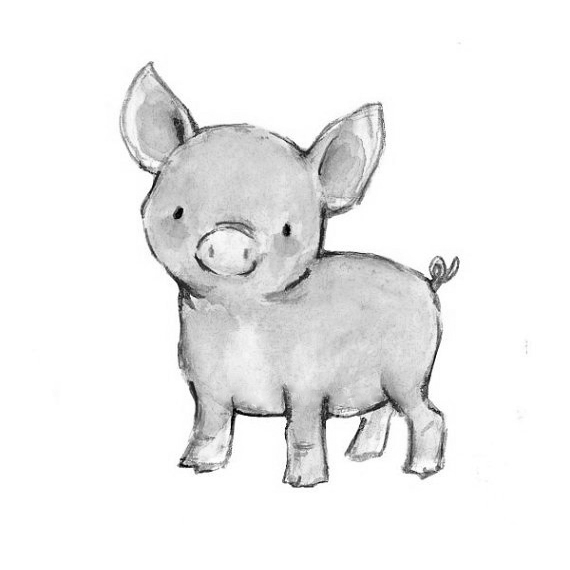

In [25]:
from PIL import Image

x = Image.open('pig.jpg').convert('L')
x

In [26]:
img_size = (28, 28)
x = x.resize(img_size)
x1 = np.reshape(x, (28, 28, 1))
x1 = np.transpose(x1, [2, 0, 1])
x2 = np.expand_dims(x, 0)
np.array_equal(x1, x2)
x

In [29]:
x2.dtype

dtype('uint8')

In [64]:
torch.cuda.memory_allocated()

31207424